In [16]:
import os
import sys
from tqdm import tqdm
import torch
from transformers import BertTokenizerFast
import lightning as pl

In [17]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))  
pl.seed_everything(42, workers=True)
torch.set_float32_matmul_precision(precision="high")

Seed set to 42


In [18]:
args = {
    "pretrain": '/home/zhulin/pretrain/bert_pretrain_uncased/',
    "model": "/mnt/sdd1/data/zhulin/jack/models/DeepGuard-100.ckpt",
    "tfidf": "../common/tfidf.ph",
    "fasttext": "../common/fasttext.ph",
    "dataset": "/home/zhulin/datasets/cdatasets.test.5.csv",
    "batch_size": 4
}


In [19]:
class Timer:
    def __init__(self):
        # 设置用于测量时间的 cuda Event, 这是PyTorch 官方推荐的接口,理论上应该最靠谱
        self.starter = torch.cuda.Event(enable_timing=True)
        self.ender = torch.cuda.Event(enable_timing=True)

    def warmup(self, epochs, interface, *args, **kwargs):
        # 预热, GPU 平时可能为了节能而处于休眠状态, 因此需要预热
        with torch.no_grad():
            for _ in tqdm(range(epochs)):
                interface(*args, **kwargs)
        torch.cuda.synchronize()

    def measure(self, epochs, interface, *args, **kwargs):
        timeings = []
        for _ in tqdm(range(epochs)):
            self.starter.record()
            interface(*args, **kwargs)
            self.ender.record()
            torch.cuda.synchronize() # 等待GPU任务完成
            t = self.starter.elapsed_time(self.ender)
            
            timeings.append(t)
        return timeings

In [20]:
### load model
# tokenizer = BertTokenizerFast.from_pretrained(args["pretrain"], use_fast=True)
# predictor = torch.jit.load(args["model"])

import pickle
from gensim.models import FastText
from core.predictor import DeepGuardPredictor
# ckpt = torch.load(args["model"])
# predictor = DeepGuardPredictor(**ckpt["hyper_parameters"])
# predictor.load_state_dict(ckpt["state_dict"])
# tv = pickle.load(open(args["tfidf"], "rb"))
# fasttext = FastText.load(args["fasttext"])
tv = pickle.load(open("/home/zhulin/workspace/Sun-core/ckpt/ScETTask/TfidfVectorizer.ckpt", "rb"))
clf = pickle.load(open("/home/zhulin/workspace/Sun-core/ckpt/ScETTask/ExtraTreesClassifier.ckpt", "rb"))

In [4]:
### load datasets
import datatable as dt

data = dt.fread(args["dataset"], fill=True, max_nrows=128 * args["batch_size"]).to_pandas()

NameError: name 'args' is not defined

In [22]:
# @torch.no_grad()
# def interface(tokenizer, predictor, data, batchsize):
#     for l in range(0, len(data), batchsize):
#         padded_sent_seq = tokenizer(data.iloc[l:l+batchsize]["channel"].to_list(), padding=True, truncation=True, max_length=2048, return_tensors="pt")
#         predictor(padded_sent_seq["input_ids"].cuda(), padded_sent_seq["attention_mask"].cuda())

# @torch.no_grad()
# def interface(tv, fasttext, predictor, data, batchsize):
#     for l in range(0, len(data), batchsize):
#         tokenizer  = tv.build_tokenizer()
#         df = data.iloc[l:l+batchsize].copy()
#         df["tokens"] = df["channel"].apply(lambda seq: tokenizer(seq.lower()))
#         df["length"] = df["tokens"].apply(lambda tokens: min(2048, len(tokens)))
#         maxlen = min(df["length"].max(), 2048)

#         tfidfs, vecs = [], []
#         for token in df["tokens"].to_list():
#             tfidf = torch.zeros(size=(maxlen,), dtype=torch.float32)
#             vec = torch.zeros(size=(maxlen, 64), dtype=torch.float32)
#             for i, t in enumerate(token[:maxlen]):
#                 tfidf[i] = tv.idf_[tv.vocabulary_.get(t, np.argmin(tv.idf_))]
#                 vec[i] = torch.from_numpy(fasttext.wv.get_vector(t, True))
#             tfidfs.append(tfidf)
#             vecs.append(vec)
#         predictor(torch.stack(tfidfs).cuda(), torch.stack(vecs).cuda(), torch.from_numpy(df["length"].to_numpy()).cuda())


# @torch.no_grad()
# def interface(predictor, data, batchsize):
#     for l in range(0, len(data), batchsize):
#         events = ["ProcessStart", "ProcessEnd", "ThreadStart", "ThreadEnd", "ImageLoad", "FileIOWrite", "FileIORead", "FileIOFileCreate", "FileIORename", "FileIOCreate", "FileIOCleanup", "FileIOClose", "FileIODelete", "FileIOFileDelete", "RegistryCreate", "RegistrySetValue", "RegistryOpen", "RegistryDelete", "RegistrySetInformation", "RegistryQuery", "RegistryQueryValue", "CallStack"]
#         x = [data["channel"].apply(lambda x:x.count(event)).to_numpy() for event in events]
#         X = np.vstack(x).T.astype(np.float32)
#         predictor(torch.from_numpy(X).cuda())


@torch.no_grad()
def interface(predictor, tv, data, batchsize):
    tokenizer  = tv.build_tokenizer()
    for l in range(0, len(data), batchsize):
        df = data.iloc[l:l+batchsize].copy()
        df["tokens"] = df["channel"].apply(lambda seq: " ".join(tokenizer(seq.lower())))
        X_test = tv.transform(df["tokens"].to_numpy())
        predictor.predict(X_test)


In [23]:
# predictor.cuda().eval()
timer = Timer()
times = []

data = dt.fread(args["dataset"], fill=True, max_nrows=128 * 8).to_pandas()
# timer.warmup(interface, tokenizer, predictor, data, 8)
# timer.warmup(10, interface, clf, tv, data, 8)

for batch_size in range(4, 32, 4):
    data = dt.fread(args["dataset"], fill=True, max_nrows=128 * batch_size).to_pandas()
    t = timer.measure(16, interface, clf, tv, data, batch_size)
    times.append(sum(t)/len(t))
print(times)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [01:42<00:00,  6.42s/it]

[4632.678314208984, 4853.6942138671875, 5137.10400390625, 5537.635192871094, 5968.170166015625, 6227.828796386719, 6414.866180419922]


In [1]:
x = list(range(4, 32, 4))
t_transformer = [934.7162742614746, 1911.4823760986328, 2932.9712677001953, 3285.357131958008, 3455.0642700195312, 3560.046096801758, 3834.350570678711]
t_deepran = [50411.755126953125, 127691.78759765625, 242284.732421875, 303498.513671875, 351470.556640625, 419730.6953125, 468433.408203125]
t_deepguard = [1549.4786529541016, 2958.3955688476562, 4669.412567138672, 5690.229156494141, 6613.483642578125, 7521.523284912109, 8401.05859375]
t_extratree = [4632.678314208984, 4853.6942138671875, 5137.10400390625, 5537.635192871094, 5968.170166015625, 6227.828796386719, 6414.866180419922]

def throughput(times):
    return [batch_size * 128 * 1000 / t for t, batch_size in zip(times, range(4, 32, 4))]


Text(0.5, 0.98, '时间开销')

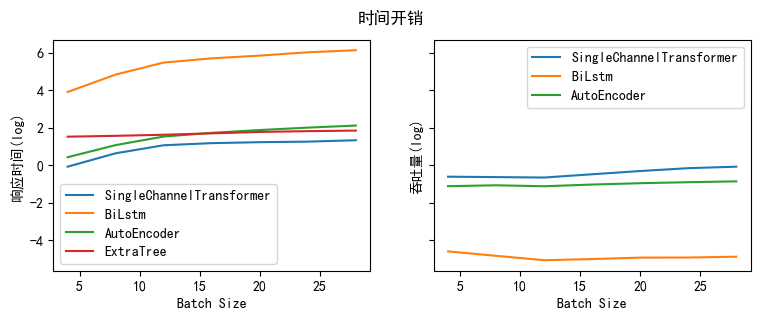

In [17]:
### 绘制
import numpy as np
import matplotlib.pyplot as plt

plt.get_cmap("Set3")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

axs[0].set_xlabel("Batch Size")
axs[0].set_ylabel("响应时间(log)")
axs[0].plot(x, np.log(np.array(t_transformer) / 1000), label="SingleChannelTransformer")
axs[0].plot(x, np.log(np.array(t_deepran) / 1000), label="BiLstm")
axs[0].plot(x, np.log(np.array(t_deepguard) / 1000), label="AutoEncoder")
axs[0].plot(x, np.log(np.array(t_extratree) / 1000), label="ExtraTree")
axs[0].legend()

axs[1].set_xlabel("Batch Size")
axs[1].set_ylabel("吞吐量(log)")
axs[1].plot(x, np.log(throughput(t_transformer)), label="SingleChannelTransformer")
axs[1].plot(x, np.log(throughput(t_deepran)), label="BiLstm")
axs[1].plot(x, np.log(throughput(t_deepguard)), label="AutoEncoder")
axs[1].legend()

fig.suptitle('时间开销')